# Description 

This script allows to download a single variable data from the CCI
dataset for a single lake according to user defined period. 
The zone will be defined by de boundaries of the polygon defining the lake. 
If there are other lakes near the specified one, they will be masked.
This script is useful for dowloading data o fa single variable for a single 
lake. Information about its boundaries is not required.


INPUT:
    <ul>
    <li>The identifier of the lake. The id of the lake is indicated 
      in the csv file containing lake metadata. This file is available 
      at the project website:
        https://climate.esa.int/documents/2528/lakescci_v2.1_metadata.csv</li>
    <li>Name of the variable in the netCDF files</li>
    <li>Land mask: the netCDF file containing the mask of the lakes in CCI dataset this file 
      is part of the dataset and is available at:
      https://dap.ceda.ac.uk/neodc/esacci/lakes/data/lake_products/L3S/v2.0.1/ESA_CCI_static_lake_mask_v2.0.1.nc</li>
    <li>first/last date</li>
    <li>version of the dataset to be download (default value 2.1.0)</li>
    <li>ouptput dir to storage the extracted data</li>
    <li>prefix (optional): to be added at the output files name</li>
    </ul>

 Reference: Carrea, L.; Crétaux, J.-F.; Liu, X.; Wu, Y.; Bergé-Nguyen,
 M.; Calmettes, B.; Duguay, C.; Jiang, D.; Merchant, C.J.; Mueller, D.;
 Selmes, N.; Simis, S.; Spyrakos, E.; Stelzer, K.; Warren, M.; Yesou,
 H.; Zhang, D. (2022): ESA Lakes Climate Change Initiative (Lakes_cci):
 Lake products, Version 2.1.0. NERC EDS Centre for Environmental Data
 Analysis, date of citation.
 https://dx.doi.org/10.5285/7fc9df8070d34cacab8092e45ef276f1
 
    
 WARNING: This script is a beta version. All controls on the input parameters
 are not (yet) available. If you find a bug, have a question or a
 suggestion, don't hesitate to contact us, it will be much appreciated :
 cci_lakes.contact@groupcls.com

 to be executed with python version >= 3.9

# key variables

Lakes_cci dataset is a merged product containing multiple variables from different thematic ECVs. The key variables are as follow:

<b>Lake Water Level (LWL):</b>
<ul><li>water_surface_height_above_reference_datum</li></ul>

<b>Lake Water Extent (LWE):</b>
<ul><li>lake_surface_water_extent</li></ul>

<b>Lake Ice Cover (LIC):</b>
<ul><li>lake_ice_cover_class</li></ul>


<b>Lake Water Extent (LWE):</b>
<ul><li>lake_surface_water_temperature</li></ul>


<b>Lake Water Leaving Reflectance (LWLR):</b>
<ul><li>chla_mean</li>
<li>turbidity_mean</li>
<li>Rwxxx with xxx: 400, 412, 443, 469, 490, 510, 531, 547, 560, 620, 645, 665, 674, 681, 709, 754, 779, 859, Rw885, 900, 1020</li></ul>


In [3]:
import os
import numpy as np
import xarray as xr
import datetime
import matplotlib.pyplot as plt
%matplotlib widget
%matplotlib inline

# Step 1: Define input parameters.

In this exemple, we download Lakes surface water temperature over Lake Victoria, one of the African Great Lakes.

The lake identifier (3) was obtained from the csv file (https://climate.esa.int/documents/2607/lakescci_v2.1.0_metadata.csv) available in the project website: (https://climate.esa.int/fr/projects/lakes/)

In our case, we are interesteb by data in 2022

In [1]:
###########################################################################################
# input parameters
###########################################################################################   

# lakes mask file 
maskfile = 'ESA_CCI_static_lake_mask_v2.1.nc'

# Id for lake Victoria: 
lake_id = 3

# variable name
varname = 'lake_surface_water_temperature'

# defining the period of time in string format: YYYY-MM-DD
# dates values must be between 1992-09-26 and 2020-12-31
mindate = '2022-01-01'
maxdate = '2022-12-31'

# version dataset (2.1.0 is the version published in April 2024)
version = '2.1'

# output
outdir = 'output/Victoria_chla'
outprefix = 'Victoria_lswt_'

In [4]:
# test if dates are in the temporal coverage

mindate = datetime.datetime.strptime(mindate, '%Y-%m-%d')
maxdate = datetime.datetime.strptime(maxdate, '%Y-%m-%d')
mindate = max([mindate, datetime.datetime(1992,9,26)])
maxdate = min([maxdate, datetime.datetime(2022,12,31)])


In [5]:
# create the output directory if it does not exist
if os.path.exists(outdir)==False:
    os.makedirs(outdir)

# Step 2: Mask creation

In this step, latitude and longitude values inside the lake are obtained from the lake mask file. The boundary values will then be used to read the data in the region covering the lake.

In [7]:

###################################################################
# create mask based on lake_id
###################################################################

mask_xr = xr.open_dataset(maskfile)
mask = mask_xr['CCI_lakeid'].values
mask_ind  = np.where(mask == lake_id)
minx = np.min(mask_ind[1][:]) - 1
maxx = np.max(mask_ind[1][:]) + 1
miny = np.min(mask_ind[0][:]) - 1
maxy = np.max(mask_ind[0][:]) + 1

mask_lake = mask[miny:maxy+1, minx:maxx+1]
mask_lake[mask_lake!=lake_id] = 0
mask_lake[mask_lake == lake_id] = 1

lat = mask_xr['lat'][miny:maxy+1].values
lon = mask_xr['lon'][minx:maxx+1].values


A good validation test is to check that the lake ID is correct by visualising the lake mask.

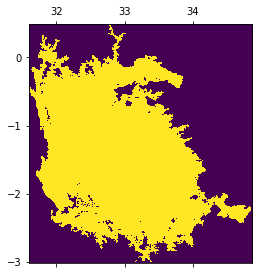

In [9]:
# plot lake mask 
plt.matshow(mask_lake, extent=[np.min(lon), np.max(lon), np.min(lat), np.max(lat)])
plt.show()

# Step 3: Data download

In this step, the data for the defined lake and variable is downloaded from each daily file and written, in netCDF format, to the output directory

In [ ]:
#### The download process

for data_date in np.arange(mindate.toordinal(), maxdate.toordinal()+1):
    current_date = datetime.datetime.fromordinal(data_date)
    date_str = current_date.strftime("%Y%m%d")
    print (f'Downloading data from lake_id {lake_id} -  ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.nc')

    path  = f'https://data.cci.ceda.ac.uk/thredds/dodsC/esacci/lakes/data/lake_products/L3S/v2.1/merged_product/'
    path += f'/{current_date.year}/{current_date.month:02}/'
    path += f'ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv2.1.0.nc?{varname}[0:1:0][{miny}:1:{maxy}][{minx}:1:{maxx}]'
   
    dataset = xr.open_dataset(path, engine="pydap" )

    filval = dataset[varname].encoding['_FillValue']
    data = dataset[varname][0,:,:].values
    data[mask_lake == 0] = filval
    dataset[varname][0,:,:] = data

    outfile = f'{outdir}/{outprefix}ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.nc'
    dataset.to_netcdf(outfile)
    